# <center>LAB04 - Textual Data</center>
##  <center>62070505204 Trirat Arromrit</center>

In [76]:
import pandas as pd
import regex as re
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('un-general-debates-blueprint.csv.gz')
df['speaker'].fillna('unknown',inplace=True) 
df.sample(3)

,session,year,country,country_name,speaker,position,text
5912,62,2007,PRK,"Korea, Democratic People's Republic of","Choe Su Hon,",Minister for Foreign Affairs,On behalf of the delegation of the Democratic...
839,32,1977,BWA,Botswana,Mogwe,NaN,"﻿149.\tLate in the day, Mr. President, allow m..."
5269,59,2004,GNB,Guinea-Bissau,Mr. Enrique Pereira Rosa,President,"Thirty years ago, my country attained its\nnat..."


In [13]:
def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

In [25]:
stopwords = set(nltk.corpus.stopwords.words('english'))
def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

In [37]:
def ngrams(tokens, n=2, sep=' ', stopwords=stopwords):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
           if len([t for t in ngram if t in stopwords])==0]

In [56]:
def ngrams2(tokens, n=2, sep=' '):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])]

In [98]:
pipeline2 = [str.lower,tokenize,remove_stop]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [99]:
pipeline = [str.lower,tokenize,remove_stop,ngrams2]
def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

In [100]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)
df['tokens1'] = df['text'].apply(prepare, pipeline=pipeline2)
df.sample(3)

,session,year,country,country_name,speaker,position,text,tokens,tokens1
2991,46,1991,MUS,Mauritius,BERENGER,NaN,"﻿Mr. President, it is indeed a pleasure for me...","[mr president, president indeed, indeed pleasu...","[mr, president, indeed, pleasure, associate, p..."
7415,70,2015,LKA,Sri Lanka,Mr. Maithripala Sirisena,President,My country is a long-standing Member of the Un...,"[country long-standing, long-standing member, ...","[country, long-standing, member, united, natio..."
4189,53,1998,LAO,Lao People's Democratic Republic,Somsavat Lengsavad,Deputy Prime Minister,"First of all, I should like to extend my\nwarm...","[first like, like extend, extend warmest, warm...","[first, like, extend, warmest, congratulations..."


In [112]:
df['tokens1']

0       [may, first, convey, president, congratulation...
1       [fortunate, coincidence, precisely, time, unit...
2       [pleasure, extend, mr, president, warmest, con...
3       [may, begin, expressing, ambassador, hambro, b...
4       [doubt, us, coming, rostrum, wonders, usefulne...
                              ...                        
7502    [behalf, people, government, yemen, would, lik...
7503    [seventy, years, passed, since, establishment,...
7504    [like, congratulate, president, country, denma...
7505    [would, like, begin, thanking, secretary-gener...
7506    [allow, outset, extend, mr, mogens, lykketoft,...
Name: tokens1, Length: 7507, dtype: object

In [63]:
def count_words(df, column='tokens', preprocess=None, min_freq = 2):
    
    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)
    
    # create counter and run through all data
    counter = Counter()
    df[column].map(update)
    
    # transform counter into a DataFrame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq > @min_freq')
    freq_df.index.name = 'Words'
    
    return freq_df.sort_values('freq', ascending=False)

In [74]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [44]:
freq_df = count_words(df)
freq_df.head(6)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856
developing countries,18511


In [68]:
digram_text1 = df.query("1970 <= year <= 1990 ")
digram_text2 = df.query("year > 1990")

## 01 - Find the top 10 word bigram from UN General Debates of years 1970 – 1990 and compare with those of years 1990 – the latest (remove stopwords first) 

In [73]:
digram_text1_freq = count_words(digram_text1)
digram_text2_freq = count_words(digram_text2)

### Top 10 words in 1970 - 1990  

In [72]:
digram_text1_freq.head(10)

,freq
Words,
united nations,43846
general assembly,13915
developing countries,11991
international community,11506
south africa,9300
united states,7718
middle east,7608
security council,7500
peace security,6755


### Top 10 words in 1990 - the latest

In [71]:
digram_text2_freq.head(10)

Top 10 words in 1990 - the latest


,freq
Words,
united nations,59398
international community,16280
security council,13472
human rights,13295
general assembly,13186
peace security,8466
developing countries,6527
member states,5941
sustainable development,5258


## 02 - Create a bigram word cloud of the UN General Debates dataset of years 1970 – 1990 and 1990 to the latest (remove stopwords first)

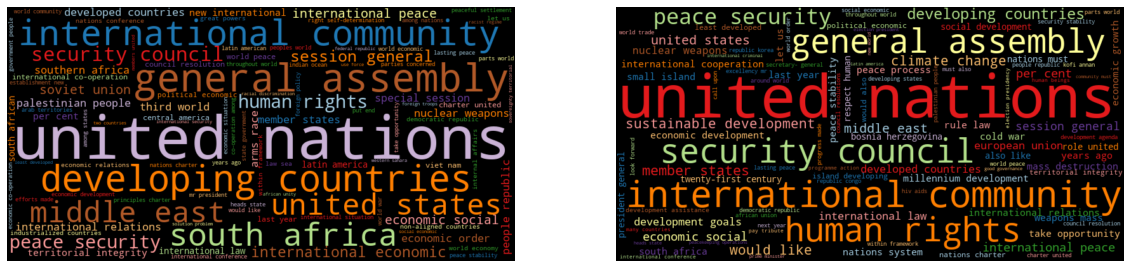

In [87]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
wordcloud(digram_text1_freq['freq'], max_words=100)
plt.subplot(1,2,2)
wordcloud(digram_text2_freq['freq'], max_words=100)

## 03 - Create a trend graph showing the bigram and word trend of “climate change”, “global warming”, “wars” and 3 others of your choices

In [121]:
keywords = ['climate change','global warming','economic development']
keyword_02 = ['wars','poverty','education']

In [102]:
def count_keywords_by(df, by, keywords, column='tokens'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]
    
    return freq_df.groupby(by).sum().sort_values(by)

In [103]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [109]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df

,climate change,global warming,economic development
year,,,
1970,0,0,42
1971,0,0,66
1972,0,0,86
1973,0,0,64
1974,0,0,74
1975,0,0,69
1976,0,0,68
1977,0,0,70
1978,0,0,66


In [122]:
freq_df_2 = count_keywords_by(df, by='year',column = 'tokens1', keywords=keyword_02)
freq_df_2

,wars,poverty,education
year,,,
1970,38,42,18
1971,85,46,21
1972,88,84,31
1973,72,79,21
1974,70,76,16
1975,54,69,30
1976,55,86,26
1977,36,93,38
1978,67,104,64


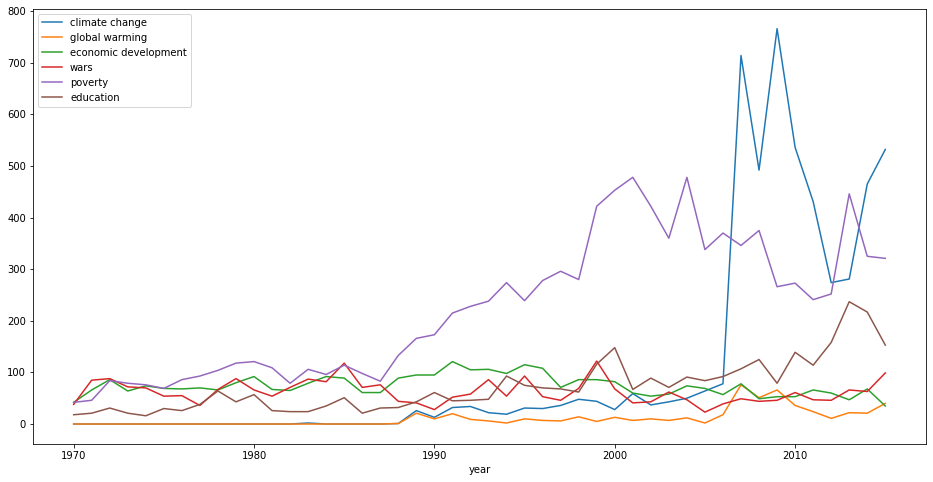

In [123]:
ax = freq_df.plot(kind='line', figsize=(16,8))
freq_df_2.plot(ax=ax)